# Translational Regulation  
10/23/15

In [7]:
# from http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import gridspec
%matplotlib inline

## Recap: Basic

### Transient heat shock

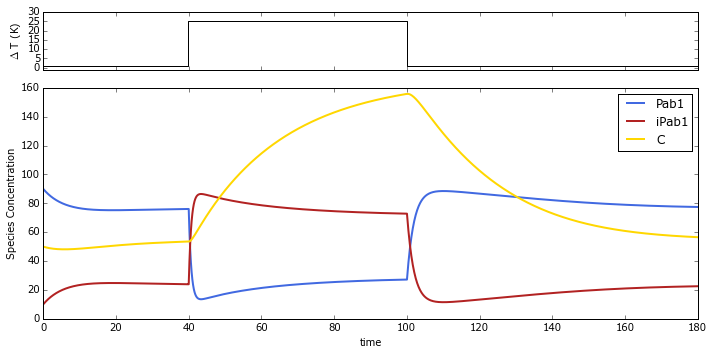

In [5]:
def deriv(z, t):
    k1 = .05 # Deactivation
    k2 = .003 # Reactivation
    k3 = .07 # Protein synthesis
    k4 = .03 # Protein degradation
    
    dPab = -k1*z[0]*T + k2*z[1]*z[2]
    diPab = -k2*z[1]*z[2] + k1*z[0]*T
    dC = k3*z[1] - k4*z[2]    
    
    return np.array([dPab, diPab, dC])

T = 1                 
time1 = np.arange(0, 40, .1)
zinit = np.array([90., 10., 50])
z1 = odeint(deriv, zinit, time1)
Tlist = [T, T]

T = 25
time2 = np.arange(40, 100, .1)
z2 = odeint(deriv, z1[-1], time2)
Tlist.append(T)

T = 1
time3 = np.arange(100, 180, .1)
z3 = odeint(deriv, z2[-1], time3)
Tlist.append(T)

times = np.concatenate((time1, time2, time3))
final = np.vstack((z1, z2, z3))


# Plots
names = ['Pab1', 'iPab1', 'C']
colors = ['royalblue', 'firebrick', 'gold']
f = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4])
ax2 = plt.subplot(gs[0])
ax2.step([time1[0], time1[-1], time2[-1], time3[-1]], Tlist, c='k')
ax2.set_ylabel('$\Delta$ T (K)')
ax2.set_ylim(-1, 30)
plt.setp(ax2.get_xticklabels(), visible=False)
ax = plt.subplot(gs[1], sharex=ax2)
for i in xrange(3):
    ax.plot(times, final[:, i], label=names[i], c=colors[i], linewidth=2)
ax.set_xlabel('time')
ax.set_ylabel('Species Concentration')
ax.legend(loc=0)
plt.tight_layout()

## Advanced

### Setup and Species

Species: **Pab**, **iPab** (insoluble _Pab1_), **C** (used relative amount of _HSP104_ as starting value, otherwise undetermined chaperone which acts catalytically), **mRNA$_C$**, **Pab:mRNA$_C$** (Pab bound to the chaperone mRNA).

Assumptions: Constant amount of Pab1. Chaperone can be translated and degraded.
b
**Chemical equations:**  
\begin{align}
Pab & \xrightarrow{k_1(T)^*} iPab
\newline
iPab + C & \xrightarrow{k_2} Pab + C
\newline
mRNA_C & \xrightarrow{k_3} C
\newline
C & \xrightarrow{k_4} \emptyset
\newline
\emptyset & \xrightarrow{k_5(T)^*} mRNA_C
\newline
Pab + mRNA_C & \overset{k_6} \leftrightharpoons Pab:mRNA_C
\newline
& \thinspace \thinspace ^{k_{-6}}
\end{align}


$^*$ (T) denotes rates that are a function of temperature

**Rate equations:**
	\begin{align}
		\frac{d[Pab]}{dt} &= k_2[Pab][C] - k_1(T)[Pab] - k_6[Pab][mRNA_C] + k_{-6}[Pab:mRNA_C]
		\newline
		\frac{d[iPab]}{dt} &= k_1(T)[Pab] - k_2[Pab][C]
		\newline
		\frac{d[C]}{dt} &= k_3[mRNA_C] - k_4[C]
		\newline
		\frac{d[mRNA_C]}{dt} &= k_5(T) - k_6[Pab][mRNA_C] + k_{-6}[Pab:mRNA_C]
		\newline
		\frac{[Pab:mRNA_C]}{dt} &= k_6[Pab][mRNA_C] - k_{-6}[Pab:mRNA_C]
	\end{align}